In [1]:
from fastai.vision.all import *
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# check if cuda is available
print(torch.cuda.is_available())

True


## define the trainer

In [3]:
# define a function to get the images
def get_images(name):
    return get_image_files("/kaggle/input/car-segmentation/train_test_split")

In [4]:
# define a function to get the numpy mask for the given path
def get_mask(path):
    #remove the file name and extension from the path
    path = path.parent 
    # add the name mask.npy to the path
    path = path.joinpath("label.npy")
    return np.load(path)

In [5]:
aerial_Block = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ["nothing","car"])),
                            splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                            get_items=get_images,
                            get_y=get_mask,
                            batch_tfms=aug_transforms(size=500, max_lighting=0.3))

In [6]:
dataloader = aerial_Block.dataloaders("./",bs=8)

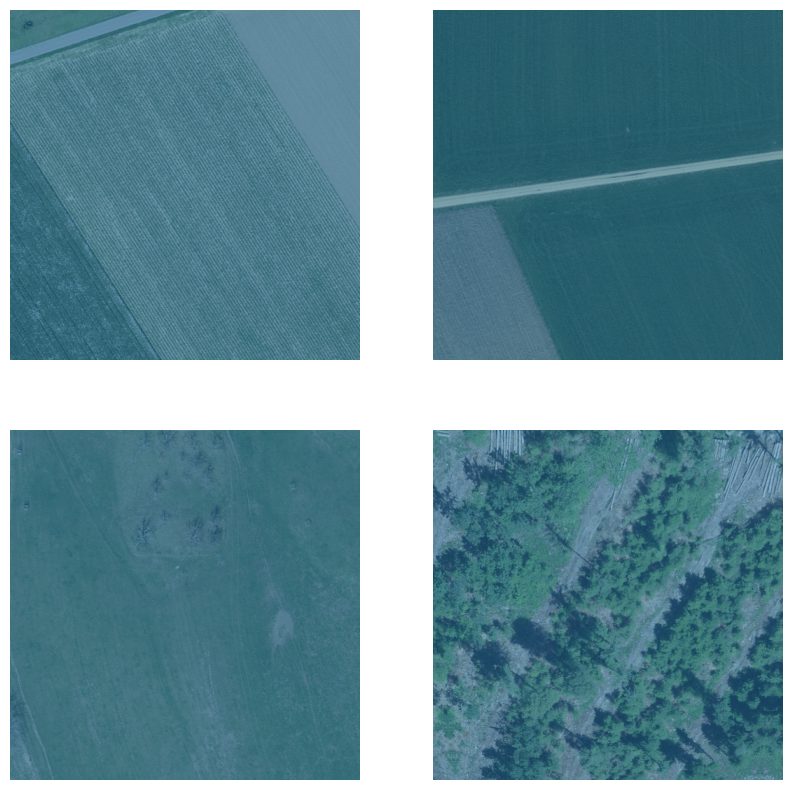

In [7]:
dataloader.show_batch(max_n=4,figsize=(10,10))

## Train the Model

In [8]:
torch.cuda.empty_cache()

In [9]:
learner = unet_learner(dataloader,resnet34,metrics=Dice)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.2MB/s]


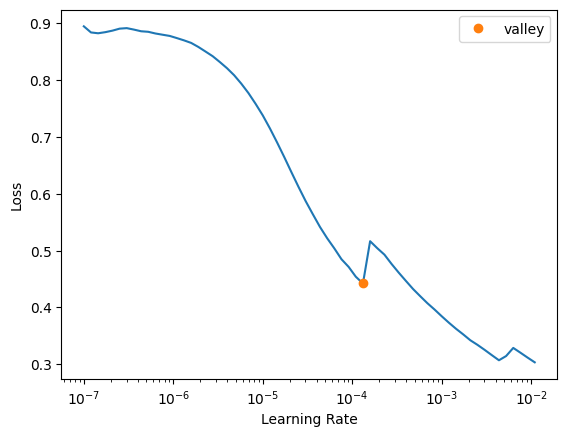

In [10]:
lr = learner.lr_find()

In [11]:
learner.fit_one_cycle(20, lr_max=lr.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=5, comp=np.greater),
                                           SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_model')])

epoch,train_loss,valid_loss,dice,time
0,0.032727,0.016934,0.000263,02:35
1,0.008746,0.005187,0.207976,02:34
2,0.007004,0.003768,0.498638,02:34
3,0.004488,0.003953,0.580919,02:34
4,0.003802,0.004761,0.562315,02:34
5,0.003373,0.002949,0.563235,02:34
6,0.004084,0.003550,0.577094,02:34
7,0.003049,0.002762,0.632928,02:34
8,0.002909,0.003047,0.670847,02:34
9,0.003090,0.002578,0.698787,02:34


Better model found at epoch 0 with dice value: 0.00026266367230080243.
Better model found at epoch 1 with dice value: 0.20797567561634211.
Better model found at epoch 2 with dice value: 0.4986378283739218.
Better model found at epoch 3 with dice value: 0.5809194260128709.
Better model found at epoch 7 with dice value: 0.6329277468289013.
Better model found at epoch 8 with dice value: 0.6708467466041524.
Better model found at epoch 9 with dice value: 0.6987868875234444.
Better model found at epoch 11 with dice value: 0.7250376816997098.
No improvement since epoch 11: early stopping


## unfreeze and retrain

In [12]:
learner = learner.load('best_frozen_model')
learner.unfreeze()

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


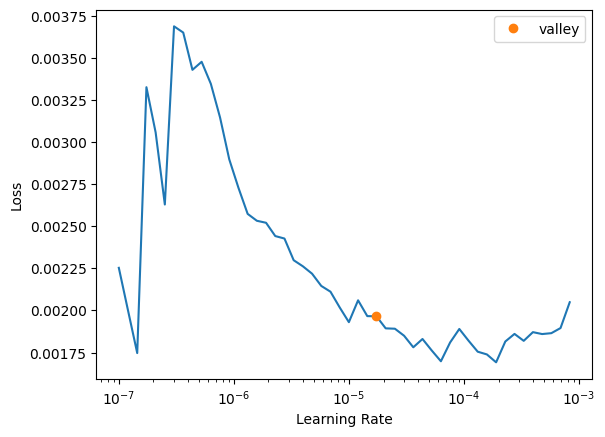

In [13]:
lr = learner.lr_find()

In [14]:
learner.fit_one_cycle(
    20, lr_max=slice(lr.valley/10,lr.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.005, patience=5, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.002192,0.002370,0.713725,02:39
1,0.002202,0.002408,0.699683,02:39
2,0.002480,0.002293,0.680925,02:39
3,0.002469,0.002528,0.716680,02:39
4,0.002745,0.002951,0.689355,02:39
5,0.002163,0.002119,0.735053,02:39
6,0.002416,0.002180,0.744223,02:39
7,0.001795,0.002436,0.736216,02:39
8,0.001753,0.002771,0.716406,02:39
9,0.001608,0.001942,0.768567,02:40


Better model found at epoch 0 with dice value: 0.7137251916629397.
Better model found at epoch 3 with dice value: 0.7166801694712656.
Better model found at epoch 5 with dice value: 0.7350531581130376.
Better model found at epoch 6 with dice value: 0.7442233162576506.
Better model found at epoch 9 with dice value: 0.7685666728826085.
Better model found at epoch 10 with dice value: 0.7784038047403109.
No improvement since epoch 10: early stopping
